In [4]:
#   import necessary dependencies
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import arff
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

print("dependencies imported")

dependencies imported


In [5]:
#   functions! Inspired by https://gogul.dev/software/ml/logistic-regression-from-scratch
#   we will use l2 regularization because your slides at the time of my programming this don't mention anything about a regularization algorithm

# normalize score output
def make01(score):
    return (1 / (1 + np.exp(-score)))

# get score for prediction
def predict_probabilities(features, weights):
    score = np.dot(features, weights)
    return make01(score)

# need 'quality' metric that compares the prediction with the original class value
def get_log_likelihood(features, labels, weights, l2_penalty):
    indicator = (labels==+1)
    scores    = np.dot(features, weights)
    ll        = np.sum((np.transpose(np.array([indicator]))-1)*scores - np.log(1. + np.exp(-scores))) - (l2_penalty * np.sum(weights[1:]**2))
    return ll

def get_f_measure(features, weights, targets):
    scores = (predict_probabilities(features, weights).flatten()>0.5)
    #tp, tn, fp, fn = true positive, true negative, false positive, false negative
    tp, tn, fp, fn = compare_results(scores, targets)

    pre = tp/(tp+fn)
    rec = tp/(tp+fn)

    return (2*pre*rec)/(pre+rec)

def compare_results(scores, targets):
    tp, tn, fp, fn = 0, 0, 0, 0

    for i in range(scores.shape[0]):
        # print("working? ", scores[i], targets[i])
        if scores[i] == targets[i]:
            if scores[i] == 1:
                tp+=1
            elif scores[i] == 0:
                tn+=1
        elif scores[i] != targets[i]:
            if scores[i] == 1:
                fp+=1
            elif scores[i] == 0:
                fn+=1

    # print("tp: {} tn: {} fp: {} fn: {}".format(tp, tn, fp, fn))
    return tp, tn, fp, fn

def feature_derivative(errors, feature, weight, l2_penalty, feature_is_constant):
    derivative = np.dot(np.transpose(errors), feature)
  
    if not feature_is_constant:
        derivative -= 2 * l2_penalty * weight

    return derivative

def log_regression(features, labels, learning_rate, epochs, l2_penalty):

    #add initial bias
    bias = np.ones((features.shape[0], 1))
    features = np.hstack((bias, features))

    #initialize weights to 0 because they'll be changed by the algorithm anyway
    weights = np.zeros((features.shape[1], 1))

    #stuff to print
    logs = []

    # run though all the epocs
    for epoch in range(epochs):

        # predict the probability for the data
        probabilities = predict_probabilities(features, weights)

        # indicator value
        indicators = (labels==+1)

        # get errors for predicted probabilities
        errors = np.transpose(np.array([indicators])) - probabilities

        # for every weight
        for weight in range(len(weights)):

            isIntercept = (weight == 0)

            derivative = feature_derivative(errors, features[:, weight], weights[weight], l2_penalty, isIntercept)
            weights[weight] += learning_rate * derivative
        
        # loglikelihood = get_log_likelihood(features, labels, weights, l2_penalty)
        # logs.append(loglikelihood)
        fm = get_f_measure(features, weights, labels)
        logs.append(fm)
    
    x = np.linspace(0, len(logs), len(logs))
    fig = plt.figure()
    plt.plot(x, logs)
    plt.xlabel('Epoch')
    plt.ylabel('F-Measure')
    plt.show()

    return weights


In [6]:
#   load the data
filename = '../chronic_kidney_disease_full.arff'
data = arff.load(open('../chronic_kidney_disease_full.arff'))
df = pd.DataFrame(data['data'])

def standardize_data(df):
    df = df.copy(deep=True)


def log_regression_unnormalized(data, learning_rate=1e-10, num_epoch=50000, l2_penalty=2, normalized=False):
    
    df = data.copy(deep=True)
    #last column of df is our target column in terms of ckd, notckd
    target = df.iloc[:, -1:]
    df.drop(df.columns[[24]], axis=1, inplace=True)

    target = target.rename({24: 1}, axis=1)
    target = target.replace("ckd", 1)
    target = target.replace("notckd", 0)
    target = target.T
    target = target.to_numpy()[0]
    # print(target)

    # format data oh god
    df = df.replace("yes", 1)
    df = df.replace("no", 0)
    df = df.replace("present", 1)
    df = df.replace("notpresent", 0)
    df = df.replace("normal", 1)
    df = df.replace("abnormal", 0)
    df = df.replace("good", 1)
    df = df.replace("poor", 0)
    df = df.replace("1.005", 1.005)
    df = df.replace("1.010", 1.01)
    df = df.replace("1.015", 1.015)
    df = df.replace("1.020", 1.020)
    df = df.replace("1.025", 1.025)
    df = df.replace("0", 0)
    df = df.replace("1", 1)
    df = df.replace("2", 2)
    df = df.replace("3", 3)
    df = df.replace("4", 4)
    df = df.replace("5", 5)
    df = df.replace("None", -1)
    df = df.fillna(-1)
    # print(df.dtypes)

    if normalized:
        print("Standardizing Data...")
        scaler = StandardScaler()
        df = scaler.fit_transform(df)
        print("Data mean should be near 0:", df.mean())
        print("Data standard deviation should be 1:", df.std())
        print("-----")
        df = pd.DataFrame(df)
    
    #print(df)
    #print(target)
    
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.20, random_state=5)
    print("X_train : " + str(X_train.shape))
    print("y_train : " + str(y_train.shape))
    print("X_test : " + str(X_test.shape))
    print("y_test : " + str(y_test.shape))

    # get learned weights
    learned_weights = log_regression(X_train, y_train, learning_rate, num_epoch, l2_penalty)

    bias_train = np.ones((X_train.shape[0], 1))
    bias_test = np.ones((X_test.shape[0], 1))
    features_train = np.hstack((bias_train, X_train))
    features_test = np.hstack((bias_test, X_test))

    test_predictions = (predict_probabilities(features_test, learned_weights).flatten()>0.5)
    train_predictions = (predict_probabilities(features_train, learned_weights).flatten()>0.5)
    print("LR Accuracy on Training Data: ", accuracy_score(np.expand_dims(y_train, axis=1), train_predictions))
    print("LR Accuracy on Test Data: ", accuracy_score(np.expand_dims(y_test, axis=1), test_predictions))


X_train : (320, 24)
y_train : (320,)
X_test : (80, 24)
y_test : (80,)


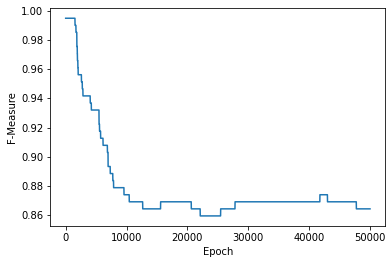

LR Accuracy on Training Data:  0.821875
LR Accuracy on Test Data:  0.75


In [7]:
log_regression_unnormalized(df)

Standardizing Data...
Data mean should be near 0: 1.258252761241844e-17
Data standard deviation should be 1: 1.0
-----
X_train : (320, 24)
y_train : (320,)
X_test : (80, 24)
y_test : (80,)


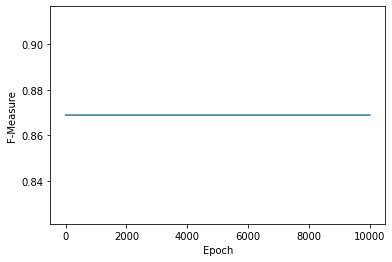

LR Accuracy on Training Data:  0.90625
LR Accuracy on Test Data:  0.9


In [8]:
log_regression_unnormalized(df, num_epoch=10000, normalized=True)